# Image Denosing

This note book contains every method and python program used in this project. Includes:
- image pre processing
- MLN method to denoise image
- LNC and early stop method to denoise image
- unfinished LNC to do inference job on Cora database

### Image pre-processing
- Transfer color image to grey scale

In [221]:
from PIL import Image

def convert_to_binary_image(image_path, output_path, size=400):
  """
  transfer PNG image to 400*400 binary image

  Args:
      image_path: PNG path
      output_path: out put path
      size: image size
  """

  # open image
  img = Image.open(image_path).convert("L")  # grey
  
  # resizing
  img = img.resize((size, size))

  # convert to binary
  threshold = 100 # thresh hold
  img = img.point(lambda p: 255 if(p > threshold) else 0)  # 

  # save image
  img.save(output_path)


image_path = "data/snake2.jpg"  # png path
output_path = "data/snake_grey2.jpg"  # out put path

convert_to_binary_image(image_path, output_path)

### Ground factor graph(MLN Markov Logic Network) and belief propagation


Time for constructing the factor graph: 0.6334 sec
RAM used for constructing the factor graph: 1201.40 MB
Belief Propagation time cost: 5.8610 sec
BP process RAM cost: 1201.40 MB


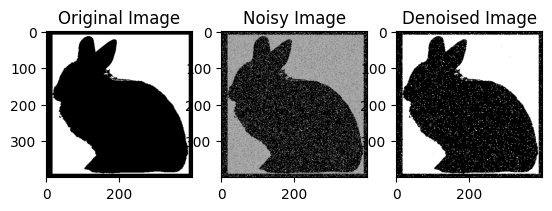

In [197]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.special import expit
import time
import os
import psutil

# make noise
def pixel_value(x, y, img, noise_rate=0.1):
  if np.random.rand() < noise_rate:
    return 1 - img[x, y]
  else:
    return img[x, y]



# markov network
def mln(img, noise_rate=0.1):
  start_time = time.time()
  size = img.shape[0]
  img = img*2-1
  # factor graph initial
  factors = {}
  for x in range(size):
    for y in range(size):
      # every pixel is a node
      factors[(x, y)] = {}
      # connect neighbor nodes
      for dx in [-1, 1]:
        if 0 <= x + dx < size:
          factors[(x, y)][(x + dx, y)] = 1
      for dy in [-1, 1]:
        if 0 <= y + dy < size:
          factors[(x, y)][(x, y + dy)] = 1
      # connect self node
      factors[(x, y)][(x, y)] = 2.1
  # add random noise
  noisy_img = np.array([[pixel_value(x, y, img, noise_rate) for y in range(size)] for x in range(size)])
  end_time = time.time()
  print(f"Time for constructing the factor graph: {end_time - start_time:.4f} sec")
  process = psutil.Process(os.getpid())
  print(f"RAM used for constructing the factor graph: {process.memory_info().rss / 1024 / 1024:.2f} MB")  # MB
  return factors, noisy_img


# define belief propagation algorithm
def belief_propagation(factors, noisy_img, tolerance=1e-3):
  """
  implement belief propagation algorithm, when belief change 
  smaller than tolerance, stop iteration

  Args:
    factors: factor graph。
    noisy_img: image with noise
    tolerance: tolerance

  Returns:
    beliefs: out put image after BP。
  """
  start_time = time.time()
  size = noisy_img.shape[0]
  # initial belief
  beliefs = np.zeros((size, size))
  prev_beliefs = np.zeros((size, size))
  while(True):
    # update belief
    for x in range(size):
      for y in range(size):
        # calculate message from neighbor
        messages = np.array([factors[(x, y)][neighbor] * expit(beliefs[neighbor[0], neighbor[1]])*noisy_img[neighbor[0],neighbor[1]] for neighbor in factors[(x, y)]])
        # update belief
        beliefs[x, y] = expit(np.sum(messages))
    
    # check if converge
    diff = np.max(np.abs(beliefs - prev_beliefs))
    if diff < tolerance:
      break

    # update old belief
    prev_beliefs = np.copy(beliefs)
    
  end_time = time.time()
  print(f"Belief Propagation time cost: {end_time - start_time:.4f} sec")
  process = psutil.Process(os.getpid())
  print(f"BP process RAM cost: {process.memory_info().rss / 1024 / 1024:.2f} MB")  # MB unit
  
  return beliefs

# main
if __name__ == "__main__":
  # original image
  img = np.array(Image.open("data/rabbit2.png"))
  img = img/255
  # create factor graph and image with noise
  factors, noisy_img = mln(img)
  # belief propagation
  beliefs = belief_propagation(factors, noisy_img)
  # show result
  plt.subplot(1, 3, 1)
  plt.imshow(img, cmap="gray")
  plt.title("Original Image")
  plt.subplot(1, 3, 2)
  plt.imshow(noisy_img, cmap="gray")
  plt.title("Noisy Image")
  plt.subplot(1, 3, 3)
  plt.imshow(beliefs>0.75, cmap="gray")
  plt.title("Denoised Image")
  plt.show()

### Use early stop technology to build Lifted Network Construction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy.sparse import lil_matrix
import time
import os
import psutil

# make noise
def pixel_value(x, y, img, noise_rate=0.1):
  if np.random.rand() < noise_rate:
    return 1 - img[x, y]
  else:
    return img[x, y]

def mln_lifted_denoise(img, noise_rate=0.1,block_size=4):
  """
  使用更复杂的超节点和超特征进行图像去噪。

  Args:
    img: 原始图像。
    noise_rate: 噪声比例。

  Returns:
    beliefs: 去噪后的图像。
  """
 
  start_time = time.time()
  size = img.shape[0]

  # 构建超节点
  noisy_img = np.array([[pixel_value(x, y, img, noise_rate) for y in range(size)] for x in range(size)])
  noisy_img = noisy_img*2-1
  supernodes = []
  for i in range(0, size, block_size):
    for j in range(0, size, block_size):
      block = noisy_img[i:i + block_size, j:j + block_size]
      supernodes.append(np.where(block == 1))  # 块中观测值为 1 的像素
      supernodes.append(np.where(block == -1))  # 块中观测值为 -1 的像素

  # 构建超特征 (与之前相同)
  superfactor_weights = lil_matrix((len(supernodes), len(supernodes))) 

  # 相邻超节点之间的连接
  for i in range(len(supernodes)):
    for x1, y1 in zip(*supernodes[i]):
      for j in range(i, len(supernodes)):
        for x2, y2 in zip(*supernodes[j]):
          if abs(x1 - x2) <= block_size and abs(y1 - y2) <= block_size and (x1 != x2 or y1 != y2):
            superfactor_weights[i, j] += 1
            if i != j:
              superfactor_weights[j, i] += 1

  # 超节点内部的连接
  for i in range(len(supernodes)):
    for x1, y1 in zip(*supernodes[i]):
      for x2, y2 in zip(*supernodes[i]):
        if abs(x1 - x2) <= 1 and abs(y1 - y2) <= 1 and (x1 != x2 or y1 != y2):
          superfactor_weights[i, i] += 2.1

  end_time = time.time()
  print(f"构建 lifted 因子图用时: {end_time - start_time:.4f} 秒")
  process = psutil.Process(os.getpid())
  print(f"当前进程内存使用量: {process.memory_info().rss / 1024 / 1024:.2f} MB")

  # 执行 lifted belief propagation (与之前相同)
  beliefs = np.zeros((size, size))
  prev_beliefs = np.zeros((size, size))
  while True:
    # 更新置信度
    for i in range(len(supernodes)):
      messages = 0
      for j in range(len(supernodes)):
        if superfactor_weights[i, j] > 0:
          neighbor_beliefs = [beliefs[x, y] for x, y in zip(*supernodes[j])]
          messages += superfactor_weights[i, j] * expit(np.mean(neighbor_beliefs))
      for x, y in zip(*supernodes[i]):
        beliefs[x, y] = expit(messages)

    # 检查是否收敛
    diff = np.max(np.abs(beliefs - prev_beliefs))
    if diff < 1e-3:
      break

    # 更新前一次迭代的置信度
    prev_beliefs = np.copy(beliefs)

  return beliefs

# 主函数
if __name__ == "__main__":
  # original image
  img = np.array(Image.open("data/rabbit2.png"))
  img = img/255
  # 使用 lifted belief propagation 进行图像去噪
  beliefs = mln_lifted_denoise(img)
  plt.subplot(1, 3, 1)
  plt.imshow(img, cmap="gray")
  plt.title("Original Image")
  plt.subplot(1, 3, 2)
  plt.imshow(noisy_img, cmap="gray")
  plt.title("Noisy Image")
  plt.subplot(1, 3, 3)
  plt.imshow(beliefs>0.75, cmap="gray")
  plt.title("Denoised Image")
  plt.show()

Time for constructing the factor graph: 0.6569 sec
RAM used for constructing the factor graph: 1205.50 MB
LNC time: 6.2362 sec
LNC RAM used: 1235.96 MB
Lifted Belief Propagation cost time: 7.2446 sec
Lifted Belief Propagation cost RAM: 1160.00 MB


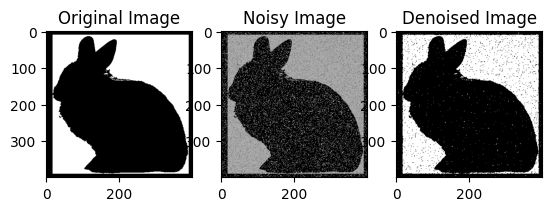

In [198]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.special import expit
import time
import os
import psutil
from collections import defaultdict

# make noise
def pixel_value(x, y, img, noise_rate=0.1):
  if np.random.rand() < noise_rate:
    return 1 - img[x, y]
  else:
    return img[x, y]


# markov network
def mln(img, noise_rate=0.1):
  start_time = time.time()
  size = img.shape[0]
  img = img*2-1
  # factor graph initial
  factors = {}
  for x in range(size):
    for y in range(size):
      # every pixel is a node
      factors[(x, y)] = {}
      # connect neighbor nodes
      for dx in [-1, 1]:
        if 0 <= x + dx < size:
          factors[(x, y)][(x + dx, y)] = 1
      for dy in [-1, 1]:
        if 0 <= y + dy < size:
          factors[(x, y)][(x, y + dy)] = 1
      # connect self node
      factors[(x, y)][(x, y)] = 2.1
      
  # add random noise
  noisy_img = np.array([[pixel_value(x, y, img, noise_rate) for y in range(size)] for x in range(size)])
  end_time = time.time()
  print(f"Time for constructing the factor graph: {end_time - start_time:.4f} sec")
  process = psutil.Process(os.getpid())
  print(f"RAM used for constructing the factor graph: {process.memory_info().rss / 1024 / 1024:.2f} MB")  # MB
  return factors, noisy_img

def lnc(factors, noisy_img, max_iterations=5):
    """
    Lifted Network Construction algorithm。

    Args:
        factors: factor graph。
        noisy_img: image with noise。
        max_iterations: LNC iteration times。

    Returns:
        supernodes: supernodes dictionary，key is super node ID，value is nodes list.
        superfactors: super factor graph，key is super factor ID，value is connected super nodes'ID and weights.
    """
    start_time = time.time()
    size = noisy_img.shape[0]
    nodes = [(x, y) for x in range(size) for y in range(size)]
    supernodes = defaultdict(list)
    for node in nodes:
        supernodes[node].append(node)  # initial, every node is a super node

    for _ in range(max_iterations):
        new_supernodes = defaultdict(list)
        node_to_supernode = {}

        # calcualte feature count for each neighbor nodes(number of neighbor and corresponding value)
        neighbor_counts = defaultdict(lambda: defaultdict(int))
        for supernode_id, supernode in supernodes.items():
            for node in supernode:
                for neighbor in factors[node]:
                    # add neighbor node's value to feature count
                    neighbor_value = noisy_img[neighbor[0], neighbor[1]]
                    neighbor_counts[node][(neighbor, neighbor_value)] += 1

        # add nodes to supernodes depends on its feature count
        for supernode_id, supernode in supernodes.items():
            for node in supernode:
                count_key = tuple(sorted(neighbor_counts[node].items()))
                new_supernodes[count_key].append(node)
                node_to_supernode[node] = count_key

        supernodes = new_supernodes

    # build super factor
    superfactors = defaultdict(lambda: defaultdict(float))
    for supernode_id, supernode in supernodes.items():
        for node in supernode:
            for neighbor, weight in factors[node].items():
                neighbor_supernode_id = node_to_supernode[neighbor]
                superfactors[supernode_id][neighbor_supernode_id] += weight

    end_time = time.time()
    print(f"LNC time: {end_time - start_time:.4f} sec")
    process = psutil.Process(os.getpid())
    print(f"LNC RAM used: {process.memory_info().rss / 1024 / 1024:.2f} MB") 
    return supernodes, superfactors

def lifted_belief_propagation(supernodes, superfactors, noisy_img, tolerance=1e-3):
    """
    Use super node to do belief propagation.

    Args:
        supernodes: super nodes dictionary.
        superfactors: super factor dictionary.
        noisy_img: image with noise.
        tolerance: convergence limit.

    Returns:
        beliefs: image after denoising
    """
    start_time = time.time()
    size = noisy_img.shape[0]
    beliefs = np.zeros((size, size))
    prev_beliefs = np.zeros((size, size))

    while True:
        # update belief
        for supernode_id, supernode in supernodes.items():
            for node in supernode:
                messages = []
                for neighbor_supernode_id, weight in superfactors[supernode_id].items():
                    neighbor_nodes = supernodes[neighbor_supernode_id]
                    neighbor_belief = np.mean([noisy_img[n[0], n[1]] for n in neighbor_nodes])
                    messages.append(weight * expit(neighbor_belief))
                beliefs[node[0], node[1]] = expit(np.sum(messages))

        # if converge?
        diff = np.max(np.abs(beliefs - prev_beliefs))
        if diff < tolerance:
            break

        # update old belief
        prev_beliefs = np.copy(beliefs)

    end_time = time.time()
    print(f"Lifted Belief Propagation cost time: {end_time - start_time:.4f} sec")
    process = psutil.Process(os.getpid())
    print(f"Lifted Belief Propagation cost RAM: {process.memory_info().rss / 1024 / 1024:.2f} MB")  
    return beliefs


    # main
if __name__ == "__main__":
    # original image
    img = np.array(Image.open("rabbit2.png"))
    img = img/255
    # create factor graph and image with noise
    factors, noisy_img = mln(img)
    # use LNC to construct super nodes and factors
    supernodes, superfactors = lnc(factors, noisy_img)
    # use Lifted Belief Propagation to do inference
    beliefs = lifted_belief_propagation(supernodes, superfactors, noisy_img)
    # show result
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img, cmap="gray")
    plt.title("Noisy Image")
    plt.subplot(1, 3, 3)
    plt.imshow(beliefs>0.98, cmap="gray")
    plt.title("Denoised Image")
    plt.show()

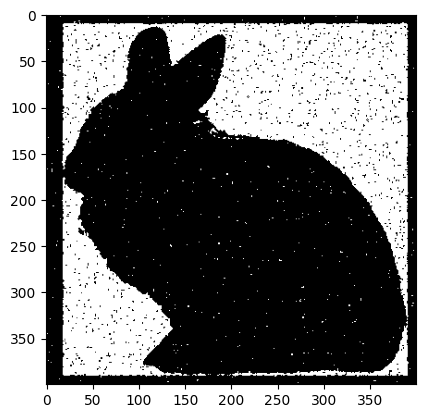

In [202]:
plt.imshow(beliefs>0.98, cmap="gray")

# Cora data base

In [ ]:
import csv

def find_att(csv_file):
    with open(csv_file,'r') as f:
        cora = csv.reader(f)
        c_row = ['' for i in range(14)]
        for row in cora:
            for i,str in enumerate(row):
                if(c_row[i]=='' and str ):
                    c_row[i] = str
            if(len([str for str in c_row if str.strip()])==14):
                break
    print('","'.join(c_row))
        
csv_file = "cora.csv"
find_att(csv_file)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


data = pd.read_csv("cora.csv", header=None, names=["ID", "Author(single)", "Authors", "Journal", "Title", "Insitute", "Book_title", "Venue", "Publisher", "Year", "Pages", "Edition", "Abstract", "Month"])

# merge authors
# data["Authors"] = data["Authors"].fillna("").apply(lambda x: ", ".join(x.split(",")))

# remove duplicate reference
# data = data.drop_duplicates(subset=["Title", "Authors", "Year", "Pages", "Publisher"])
data.fillna(" ")
# 划分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")
train_features = tfidf.fit_transform(train_data["Title"].fillna("") + " " + train_data["Authors"].fillna("") + " " + train_data["Venue"].fillna("") + " " + train_data["Pages"].fillna(""))
test_features = tfidf.transform(test_data["Title"].fillna("") + " " + test_data["Authors"].fillna("") + " " + test_data["Venue"].fillna("") + " " + test_data["Pages"].fillna(""))

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# use one-hot method encode label data

encoder = OneHotEncoder(handle_unknown='ignore')

train_titles_encoded = encoder.fit_transform(train_data["Title"].values.reshape(-1, 1))
test_titles_encoded = encoder.transform(test_data["Title"].values.reshape(-1, 1))

train_features = np.concatenate((train_features, train_titles_encoded), axis=1)
test_features = np.concatenate((test_features, test_titles_encoded), axis=1)

In [ ]:
from sklearn.linear_model import Perceptron

# voted percetron to train model
model = Perceptron(eta0=1e-5, penalty="l2", random_state=42)
model.fit(train_features, train_data["Title"])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# use Canopies remove obviouse non-matches
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(train_features)
canopies = []
for i in range(kmeans.n_clusters):
    # obtain center
    center = kmeans.cluster_centers_[i]
    # calculate cosine similarity
    distances = cosine_similarity(train_features, center.reshape(1, -1))
    # add value which less than threshold into Canopies
    canopies.append(train_data[distances > 0.8].index)

# remove Canopies 
train_data = train_data.drop(canopies)
train_features = train_features[train_data.index]